In [15]:
from root.models import *
from koe.models import *

cls = 'label'
use_gap = False
maxgap = 1000 if use_gap else 1
mingap = 1 if use_gap else -99999

database = Database.objects.get(name='Bellbird_TMI')
viewas = User.objects.get(username='superuser')
all_songs = AudioFile.objects.filter(database=database)
# all_songs = [x for x in all_songs if x.name.startswith('LBI')]
segs = Segment.objects.filter(audio_file__in=all_songs).order_by('audio_file__name', 'start_time_ms')

if use_gap:
    values = segs.values_list('id', 'audio_file__id', 'start_time_ms', 'end_time_ms')
else:
    values = segs.values_list('id', 'audio_file__id')

seg_ids = segs.values_list('id', flat=True)

label_attr = ExtraAttr.objects.get(klass=Segment.__name__, name=cls)
labels = ExtraAttrValue.objects.filter(attr=label_attr, owner_id__in=seg_ids, user=viewas).values_list('owner_id', 'value')

In [16]:
seg_id_to_label = {x: y for x, y in labels}
label_set = set(seg_id_to_label.values())
labels2enums = {y: x + 1 for x, y in enumerate(label_set)}

enums2labels = {x: y for y, x in labels2enums.items()}
# pseudo_end_id = len(label_set) + 1
# enums2labels[pseudo_end_id] = '__PSEUDO_END__'
enums2labels[0] = '__PSEUDO_BEGIN__'

seg_id_to_label_enum = {x: labels2enums[y] for x, y in seg_id_to_label.items()}

In [17]:
# Bagging song syllables by song name
songs = {}
sequences = []
sequence_ind = 1

for value in values:
    seg_id = value[0]
    song_id = value[1]

    label2enum = seg_id_to_label_enum.get(seg_id, None)
    if use_gap:
        start = value[2]
        end = value[3]
        seg_info = (label2enum, start, end)
    else:
        seg_info = label2enum

    if song_id not in songs:
        segs_info = []
        songs[song_id] = segs_info
    else:
        segs_info = songs[song_id]

    segs_info.append(seg_info)

for song_id, segs_info in songs.items():
    song_sequence = []
    has_unlabelled = False

    # This helps keep track of the current position of the syllable when the song is rid of syllable duration and
    # only gaps are retained.
    accum_gap = 10

    # This helps keep track of the gap between this current syllable and the previous one,
    # such that we can decide to merge two syllables if their gap is too small (could also be negative)
    gap = 0

    last_syl_end = None
    for ind, seg_info in enumerate(segs_info):
        if use_gap:
            label2enum, start, end = seg_info
            if last_syl_end is None:
                gap = 0
            else:
                gap = start - last_syl_end

            last_syl_end = end
            accum_gap += gap

            # If the gap is too small, merge this one with the previous one, which means the eid stays the same
            if ind > 0 and gap < mingap:
                song_sequence[-1][2].append(label2enum)
            else:
                eid = accum_gap
                song_sequence.append([sequence_ind, eid, [label2enum]])
        else:
            label2enum = seg_info
            eid = ind + 1
            song_sequence.append([sequence_ind, eid, [label2enum]])

        if label2enum is None:
            has_unlabelled = True
            break

    pseudo_start = max(0, song_sequence[0][1] - 1)
    song_sequence.insert(0, [sequence_ind, pseudo_start, [0]])
    # song_sequence.append([sequence_ind, eid + 1, [pseudo_end_id]])

    if not has_unlabelled:
        sequences += song_sequence
        sequence_ind += 1

In [18]:
from pycspade import cspade
support = max(int(len(sequences) * 0.001), 3)
result = cspade(data=sequences, support=support, maxgap=maxgap)
mined_objects = result['mined_objects']
nseqs = result['nsequences']

In [19]:
links = []
max_lift = 0
min_lift = 999999
max_noccurs = 0
min_noccurs = 9999999
for idx, seq in enumerate(mined_objects):
    items = seq.items
    lift = -1 if seq.lift is None else seq.lift
    noccurs = seq.noccurs
        
    max_lift = max(max_lift, lift)
    min_lift = min(min_lift, lift)
    max_noccurs = max(max_noccurs, noccurs)
    min_noccurs = min(min_noccurs, noccurs)

max_lift
min_thickness = 1
max_thickness = 5
min_strength = 1
max_strength = 10
        
for idx, seq in enumerate(mined_objects):
    items = seq.items
    lift = -1 if seq.lift is None else seq.lift
    noccurs = seq.noccurs
    
    if lift == -1:
        continue

    items_str = []
    if len(items) == 2:
        source_els = items[0].elements
        target_els = items[1].elements
        
        if len(source_els) != 1 or len(target_els) != 1:
            continue
        source = enums2labels[source_els[0]]
        target = enums2labels[target_els[0]]

        if source_els[0] == 0:
            continue
        
        links.append((
            source, target, {
                'strength': (lift - min_lift) / (max_thickness - min_thickness) + min_thickness,
                'thickness': (noccurs - min_noccurs) / (max_strength - min_strength) + min_strength
            }
        ))

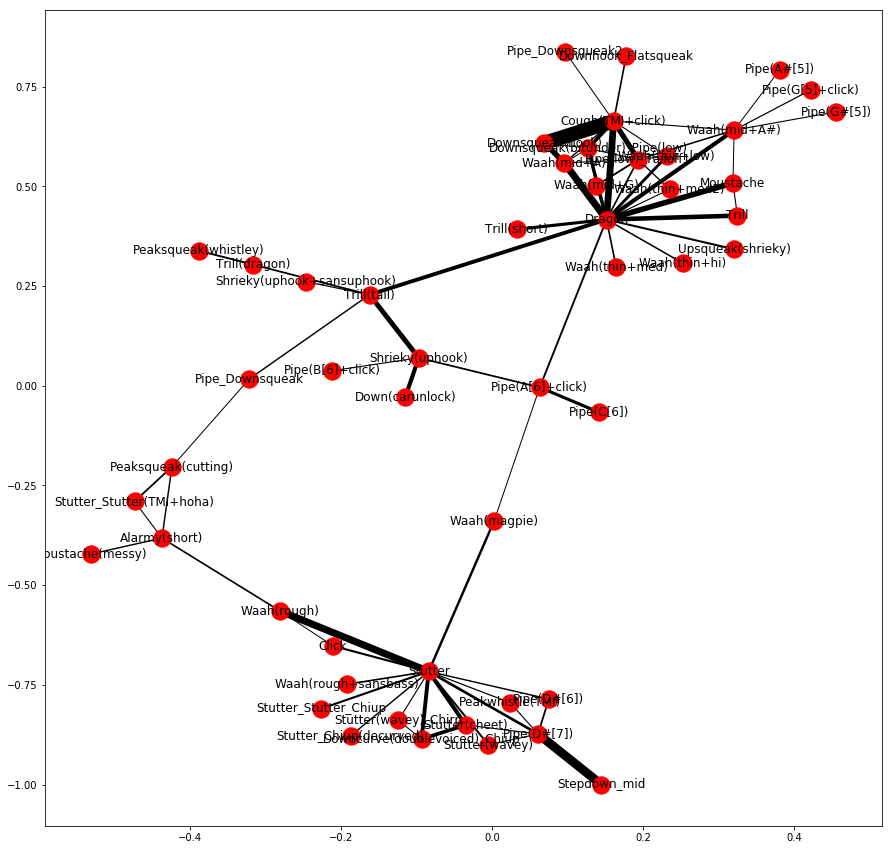

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx

G = nx.Graph()
G.add_edges_from(links)
pos = nx.spring_layout(G,weight='strength',iterations=500)

plt.figure(1,figsize=(15,15)) 
# nx.draw_networkx(G,pos,node_size=60,font_size=12)

edges = G.edges()
weights = [G[u][v]['thickness'] for u,v in edges]

nx.draw_networkx(G, pos, edges=edges, width=weights)
plt.show()

In [51]:
links

[('Waah(thin+med)',
  'Dragon',
  {'strength': 2.111111111111111, 'thickness': 1.5298251438689685}),
 ('Waah(thin+med)',
  'Waah(mid+A)',
  {'strength': 1.1111111111111112, 'thickness': 1.5072751322751323}),
 ('Pipe(A[6]+)',
  'Pipe(A[6]+)',
  {'strength': 1.0, 'thickness': 3.2760416666666665}),
 ('Pipe(A[6]+)',
  'Shrieky(uphook)',
  {'strength': 1.6666666666666665, 'thickness': 1.739513422818792}),
 ('Moggy',
  'Cough(TMI+click)',
  {'strength': 1.0, 'thickness': 1.456475583864119}),
 ('Moggy',
  'Pipe(low)_Tailoff1',
  {'strength': 1.5555555555555556, 'thickness': 2.6221340388007057}),
 ('Downsqueak(bitunder)_Pipe(low)',
  'Waah(mid+A#)',
  {'strength': 1.1111111111111112, 'thickness': 1.3384090909090909}),
 ('Downsqueak(bitunder)_Pipe(low)',
  'Pipe(G[5]+click)',
  {'strength': 1.6666666666666665, 'thickness': 1.8350601604278074}),
 ('Downsqueak(bitunder)_Pipe(low)',
  'Cough(TMI+click)',
  {'strength': 4.0, 'thickness': 1.4611682107701216}),
 ('Downsqueak(bitunder)_Pipe(low)',
  '

In [63]:
len(G.nodes)

47

In [64]:
seq.noccurs

7

In [65]:
seq

(9)->(7) - [7]